In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd

In [2]:
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 50)

In [3]:
salary_file = pd.ExcelFile('../contract_data/salaries_1985to2020_final.xlsx')
salaries = pd.read_excel(salary_file, 0)
players_info = pd.read_excel(salary_file, 1)

In [4]:
### add years of the contract
years = list(salaries.groupby('player_id').apply(lambda x: [i for i in range(1, len(x)+1)]))
flatten = lambda l: [item for sublist in l for item in sublist]
salaries['years'] = flatten(years)

In [5]:
salaries_98_20 = salaries.loc[salaries['season_end'] >= 1999]
unique_ids = list(pd.unique(salaries_98_20['player_id']))
filtered_players_info = players_info.loc[[True if pid in unique_ids else False for pid in players_info['_id']]]

In [6]:
# Deal with rookie contracts of first round picks and second round picks
# separately. 
first_round_picks = filtered_players_info.loc[filtered_players_info['draft_round'] == '1st round']
second_round_picks = filtered_players_info.loc[filtered_players_info['draft_round'] == '2nd round']

In [7]:
salaries_first_round = salaries_98_20.loc[[True if pid in list(first_round_picks['_id']) else False for pid in salaries_98_20['player_id']]].drop(columns=['team'])
# Drop entries with 'years' being 4 or less
# Prior to 2011 CBA, first round rookie contract is a 3+1 contract with the fourth year being team option
# After 2011 CBA, first round rookie contract is a 2+2 contract with both the 3rd and 4th year being team options
# Dropping values will potentially over-dropping some datapoints
salaries_first_round = salaries_first_round.loc[salaries_first_round['years'] > 4]

salaries_second_round = salaries_98_20.loc[[True if pid in list(second_round_picks['_id']) else False for pid in salaries_98_20['player_id']]].drop(columns=['team'])
# Drop entries with 'years' being 3 or less
salaries_second_round = salaries_second_round.loc[salaries_second_round['years'] > 3]

In [8]:
# Following part is for fixing data in all stats

In [9]:
stats = pd.read_excel('../season_data/advanced_stats/FINAL_ADVANCED_STATS/all_seasons_advanced_stats.xlsx')

In [10]:
stats['error_in_name'] = stats['Year'].apply(lambda x: x is np.nan)
stats_need_fix = stats.loc[stats['error_in_name'] == True]

In [11]:
stats_need_fix['Year'] = '2019-20'
name = stats_need_fix['name'].apply(lambda x: re.sub(r"\\.+", "", x))
slug = stats_need_fix['name'].apply(lambda x: re.sub(r".+\\", "", x))
stats_need_fix['name'], stats_need_fix['slug'] = name, slug

In [12]:
stats = stats.loc[stats['error_in_name'] == False].append(stats_need_fix).drop(columns=['error_in_name'])

In [13]:
# Create a primary key in two salaries table for joins
salaries_first_round['key'] = salaries_first_round['player_id'] + " " + salaries_first_round['season']
salaries_second_round['key'] = salaries_second_round['player_id'] + " " + salaries_second_round['season']
stats['key'] = stats['slug'] + " " + stats['Year']

In [14]:
salaries_stats_first_round = salaries_first_round.join(stats.set_index('key'), on='key', how='left').dropna()
salaries_stats_second_round = salaries_second_round.join(stats.set_index('key'), on='key', how='left').dropna()

In [15]:
first_round_counts = salaries_stats_first_round[['names', 'key']].groupby('key').count()
second_round_counts = salaries_stats_second_round[['names', 'key']].groupby('key').count()
not_traded_mid_season_first_round = list(first_round_counts.loc[first_round_counts['names'] == 1].index)
not_traded_mid_season_second_round = list(second_round_counts.loc[second_round_counts['names'] == 1].index)

In [16]:
salary_caps_file = pd.ExcelFile('salary_caps.xlsx')
salary_caps = pd.read_excel(salary_caps_file, 0)
salary_caps = salary_caps.drop(columns=salary_caps.columns[0])
salary_caps_99_20 = salary_caps.set_index('season').loc[np.unique(salaries_stats_first_round['season'])]

In [17]:
salaries_stats_first_round = salaries_stats_first_round.join(salary_caps_99_20, on='season', how='left')
salaries_stats_first_round = salaries_stats_first_round[salaries_stats_first_round['name'].notna()]
salaries_stats_second_round = salaries_stats_second_round.join(salary_caps_99_20, on='season', how='left')
salaries_stats_second_round = salaries_stats_second_round[salaries_stats_second_round['name'].notna()]

In [18]:
salaries_stats_first_round['cap_space_usage'] = salaries_stats_first_round['salary'] / salaries_stats_first_round['salary_cap']
salaries_stats_second_round['cap_space_usage'] = salaries_stats_second_round['salary'] / salaries_stats_second_round['salary_cap']
salaries_stats_first_round['minutes_per_game'] = salaries_stats_first_round['minutes_played'] / salaries_stats_first_round['games_played']
salaries_stats_second_round['minutes_per_game'] = salaries_stats_second_round['minutes_played'] / salaries_stats_second_round['games_played']
salaries_stats_first_round['ast/tov_percentage'] = salaries_stats_first_round['assist_percentage'] / salaries_stats_first_round['turnover_percentage']
salaries_stats_second_round['ast/tov_percentage'] = salaries_stats_second_round['assist_percentage'] / salaries_stats_second_round['turnover_percentage']
salaries_stats_first_round['true_shooting*usage'] = salaries_stats_first_round['true_shooting_percentage'] * salaries_stats_first_round['usage_percentage']
salaries_stats_second_round['true_shooting*usage'] = salaries_stats_second_round['true_shooting_percentage'] * salaries_stats_second_round['usage_percentage']

In [19]:
np.unique(salaries_stats_first_round['true_shooting*usage'])

array([ 0.    ,  0.775 ,  0.9135, ..., 24.0778, 24.948 , 41.572 ])

In [20]:
salaries_stats_first_round['ast/tov_percentage'] = salaries_stats_first_round['ast/tov_percentage'].replace([0, np.inf], np.nan)
salaries_stats_second_round['ast/tov_percentage'] = salaries_stats_second_round['ast/tov_percentage'].replace([0, np.inf], np.nan)
salaries_stats_first_round['true_shooting*usage'] = salaries_stats_first_round['true_shooting*usage'].replace([0], np.nan)
salaries_stats_second_round['true_shooting*usage'] = salaries_stats_second_round['true_shooting*usage'].replace([0], np.nan)

In [21]:
def standardize(df, column):
    series = []
    for i in df[column]:
        series.append((i - df[column].mean())/df[column].std())
    return series

def correlation(df, column_1, column_2):
    return np.mean(df[column_1] * df[column_2])

def scatter_and_correlation(df, column_1, column_2, ax, order):
    copy = df.copy()
    copy[column_1 + "_standard"] = standardize(df, column_1)
    copy[column_2 + "_standard"] = standardize(df, column_2)
    copy.plot.scatter(x = column_1 + "_standard", y = column_2 + '_standard', ax=ax[order])
    return correlation(copy, column_1 + '_standard', column_2 + '_standard')

In [22]:
def side_by_side_correlation(filtered_data, unfiltered_data, feature):
    fig, ax = plt.subplots(1,2,figsize=(10, 5))
    corr_filtered = scatter_and_correlation(filtered_data, feature, 'cap_space_usage', ax, 0)
    corr_unfiltered = scatter_and_correlation(unfiltered_data, feature, 'cap_space_usage', ax, 1)
    return (corr_filtered, corr_unfiltered, feature)

In [23]:
salaries_stats_first_round.columns

Index(['names', 'player_id', 'salary', 'season', 'season_end', 'season_start',
       'key', 'years', 'name', 'positions', 'age', 'team', 'games_played',
       'minutes_played', 'player_efficiency_rating',
       'true_shooting_percentage', 'three_point_attempt_rate',
       'free_throw_attempt_rate', 'offensive_rebound_percentage',
       'defensive_rebound_percentage', 'total_rebound_percentage',
       'assist_percentage', 'steal_percentage', 'block_percentage',
       'turnover_percentage', 'usage_percentage', 'offensive_win_shares',
       'defensive_win_shares', 'win_shares', 'win_shares_per_48_minutes',
       'offensive_box_plus_minus', 'defensive_box_plus_minus',
       'box_plus_minus', 'value_over_replacement_player', 'is_combined_totals',
       'Year', 'slug', 'salary_cap', 'cap_space_usage', 'minutes_per_game',
       'ast/tov_percentage', 'true_shooting*usage'],
      dtype='object')

In [24]:
pg_first_round = salaries_stats_first_round.loc[salaries_stats_first_round['positions'] == "POINT GUARD"].dropna()
sg_first_round = salaries_stats_first_round.loc[salaries_stats_first_round['positions'] == "SHOOTING GUARD"].dropna()
sf_first_round = salaries_stats_first_round.loc[salaries_stats_first_round['positions'] == "SMALL FORWARD"].dropna()
pf_first_round = salaries_stats_first_round.loc[salaries_stats_first_round['positions'] == "POWER FORWARD"].dropna()
c_first_round = salaries_stats_first_round.loc[salaries_stats_first_round['positions'] == "CENTER"].dropna()

In [25]:
pg_second_round = salaries_stats_second_round.loc[salaries_stats_second_round['positions'] == "POINT GUARD"].dropna()
sg_second_round = salaries_stats_second_round.loc[salaries_stats_second_round['positions'] == "SHOOTING GUARD"].dropna()
sf_second_round = salaries_stats_second_round.loc[salaries_stats_second_round['positions'] == "SMALL FORWARD"].dropna()
pf_second_round = salaries_stats_second_round.loc[salaries_stats_second_round['positions'] == "POWER FORWARD"].dropna()
c_second_round = salaries_stats_second_round.loc[salaries_stats_second_round['positions'] == "CENTER"].dropna()

In [26]:
features_pg = ['player_efficiency_rating',
              'ast/tov_percentage', 'win_shares', 'box_plus_minus',
              'value_over_replacement_player']
features_sg = ['player_efficiency_rating', 'usage_percentage',
              'ast/tov_percentage', 'true_shooting*usage', 'box_plus_minus']
features_sf = ['player_efficiency_rating',
       'usage_percentage', 'offensive_box_plus_minus',
       'value_over_replacement_player', 'ast/tov_percentage',
               'true_shooting*usage']
features_pf = ['player_efficiency_rating',
       'usage_percentage', 'offensive_box_plus_minus',
       'value_over_replacement_player', 'ast/tov_percentage',
               'true_shooting*usage']
features_c = ['player_efficiency_rating',
       'offensive_box_plus_minus',
       'value_over_replacement_player']

(0.5324568059890421, 0.5250054798049525, 'player_efficiency_rating')
(0.5060209974031739, 0.4961944572986647, 'offensive_box_plus_minus')
(0.5152959663100147, 0.5661010553137397, 'value_over_replacement_player')


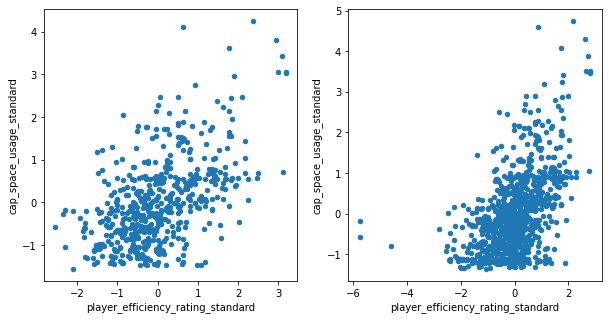

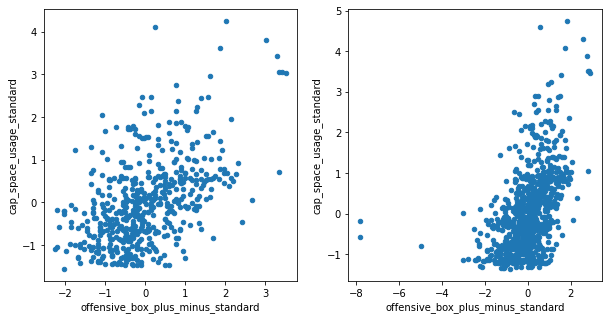

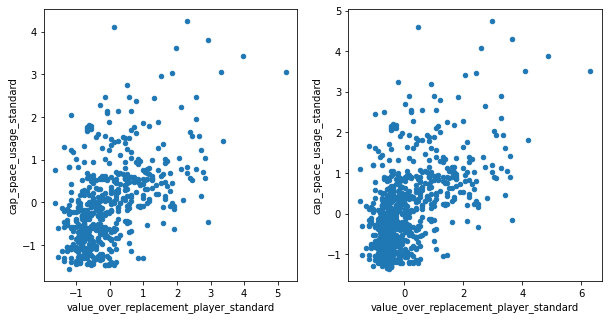

In [27]:
for feature in features_c:
    print(side_by_side_correlation(c_first_round.loc[c_first_round["minutes_played"] >= 800], c_first_round, feature))

(0.555021455761185, 0.5386199980998811, 'player_efficiency_rating')
(0.5750932451018755, 0.5204546375935609, 'usage_percentage')
(0.5323679728843643, 0.5187290954643746, 'offensive_box_plus_minus')
(0.5618469896895064, 0.5732718504081984, 'value_over_replacement_player')
(0.557480367244976, 0.49025556398819453, 'ast/tov_percentage')
(0.5557077175211136, 0.5341612905353706, 'true_shooting*usage')


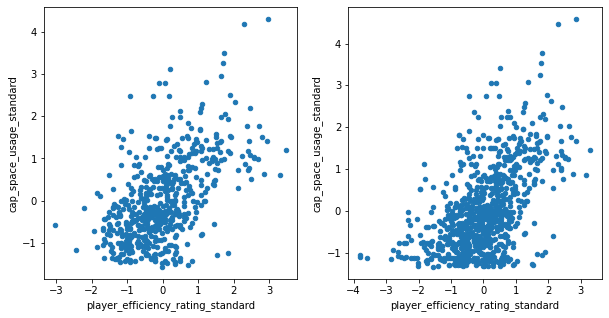

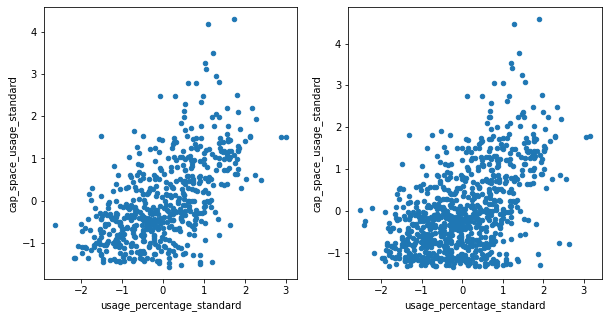

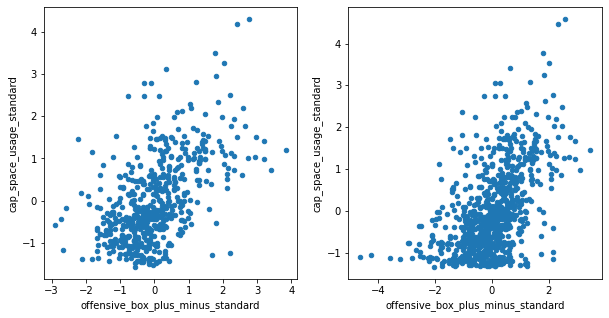

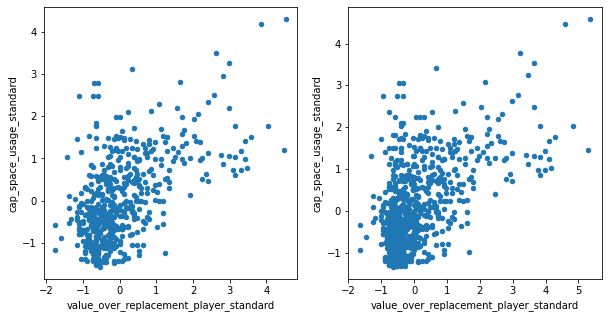

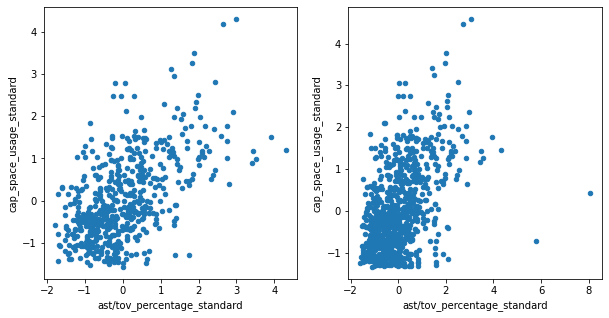

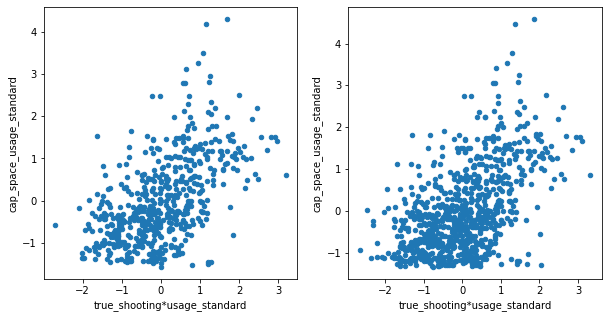

In [28]:
for feature in features_pf:
    print(side_by_side_correlation(pf_first_round.loc[pf_first_round["minutes_played"] >= 800], pf_first_round, feature))

(0.5538852802492101, 0.5366643857466098, 'player_efficiency_rating')
(0.5324664560555569, 0.49669404230699066, 'usage_percentage')
(0.5331073873410203, 0.5097558938815884, 'offensive_box_plus_minus')
(0.46731255018026646, 0.483644558293818, 'value_over_replacement_player')
(0.4579608438121476, 0.46856192847445166, 'ast/tov_percentage')
(0.5446710815235004, 0.5164580865173832, 'true_shooting*usage')


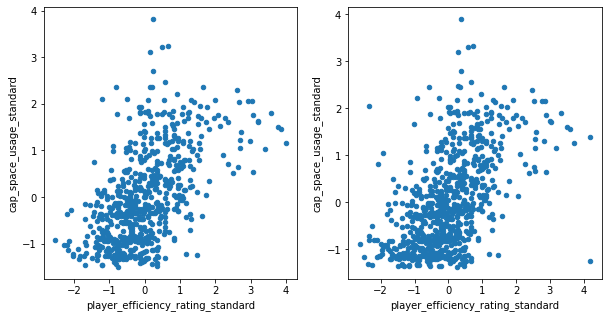

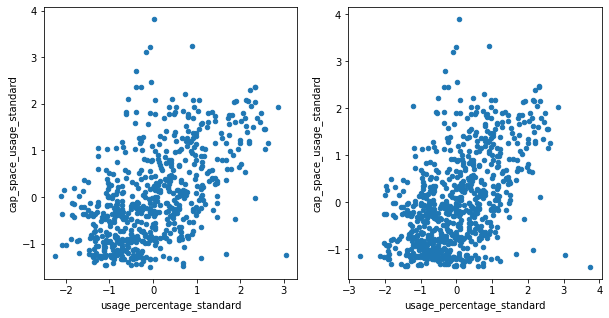

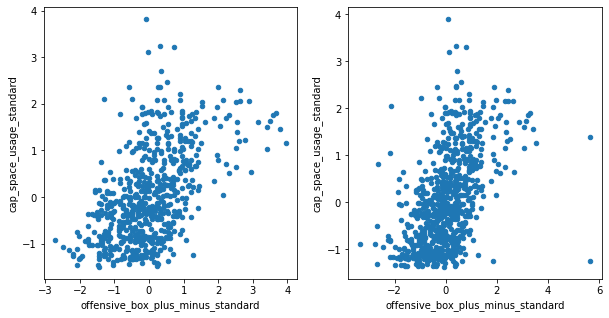

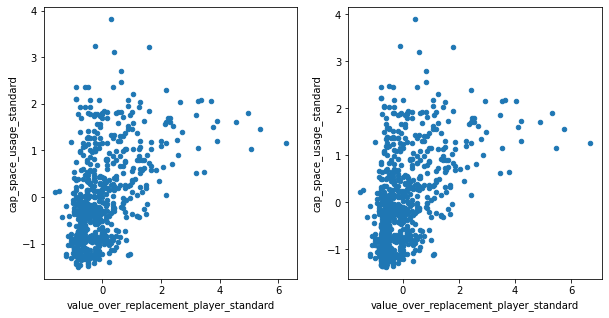

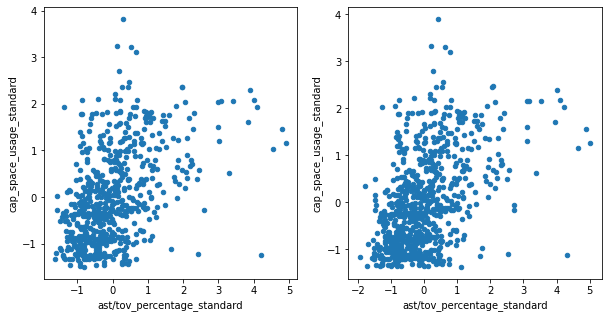

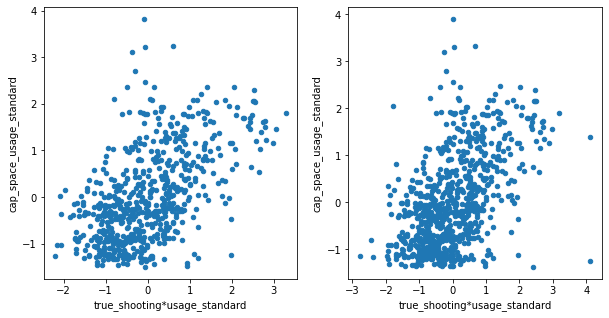

In [29]:
for feature in features_sf:
    print(side_by_side_correlation(sf_first_round.loc[sf_first_round["minutes_played"] >= 400], sf_first_round, feature))

(0.6261167131598555, 0.5449578136404457, 'player_efficiency_rating')
(0.5903112849246743, 0.5547420491842231, 'usage_percentage')
(0.574021575928129, 0.3997185001275712, 'ast/tov_percentage')
(0.6061340754618512, 0.5520934507355715, 'true_shooting*usage')
(0.5227371739584137, 0.46073468614562035, 'box_plus_minus')


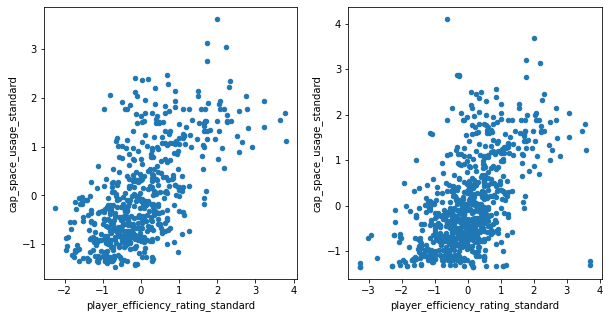

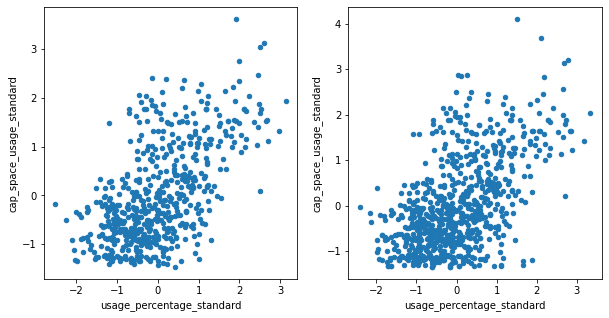

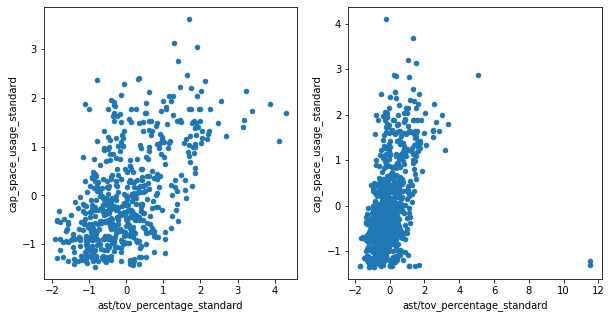

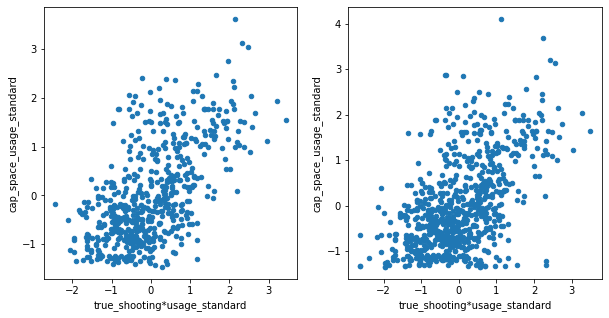

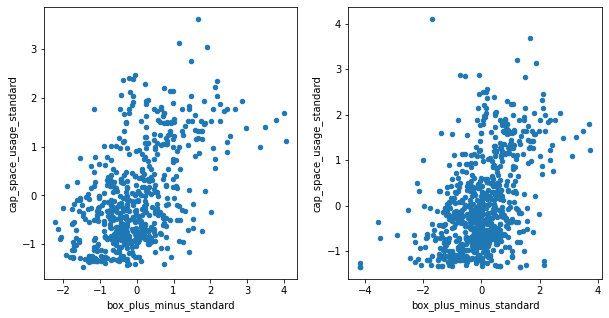

In [30]:
for feature in features_sg:
    print(side_by_side_correlation(sg_first_round.loc[sg_first_round["minutes_played"] >= 800], sg_first_round, feature))

(0.589078911075453, 0.607487551773621, 'player_efficiency_rating')
(0.5480965258508834, 0.5413967999899637, 'ast/tov_percentage')
(0.5024328847664441, 0.5713582965977426, 'win_shares')
(0.5546801451771887, 0.5750355817655407, 'box_plus_minus')
(0.5753612892875608, 0.6114338494632763, 'value_over_replacement_player')


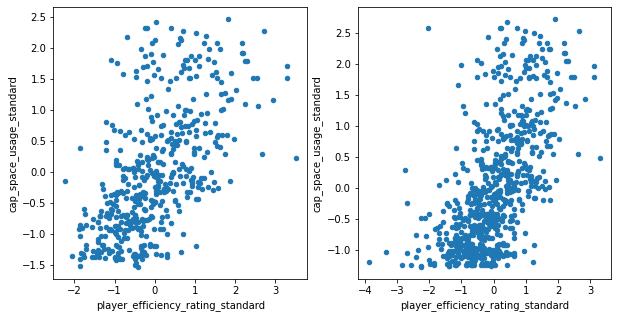

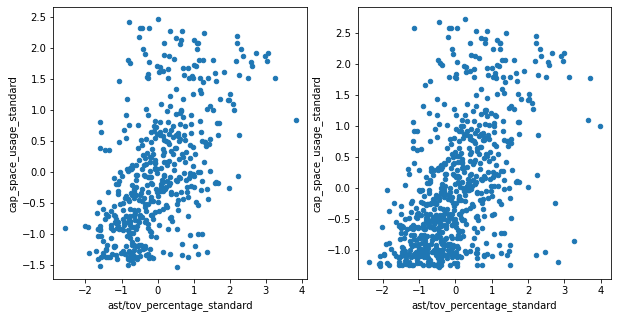

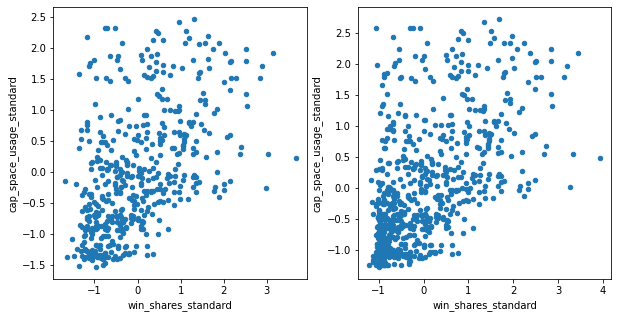

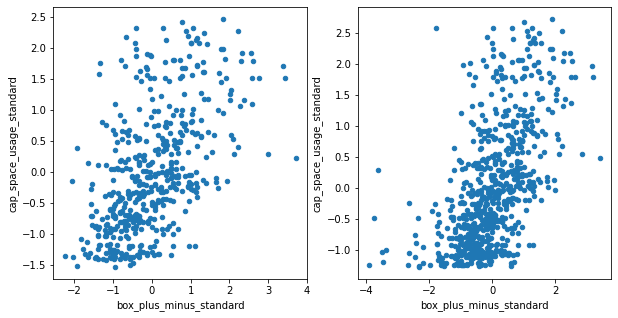

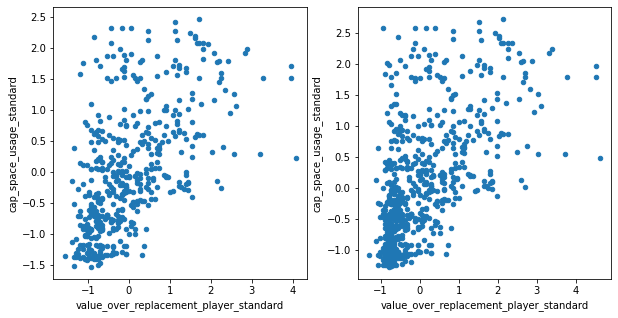

In [31]:
for feature in features_pg:
    print(side_by_side_correlation(pg_first_round.loc[pg_first_round["minutes_played"] >= 800], pg_first_round, feature))

(0.4941135287226012, 0.4486098105380043, 'player_efficiency_rating')
(0.5231396092791101, 0.486285538103889, 'offensive_box_plus_minus')
(0.5349101957853047, 0.5173187632026724, 'value_over_replacement_player')


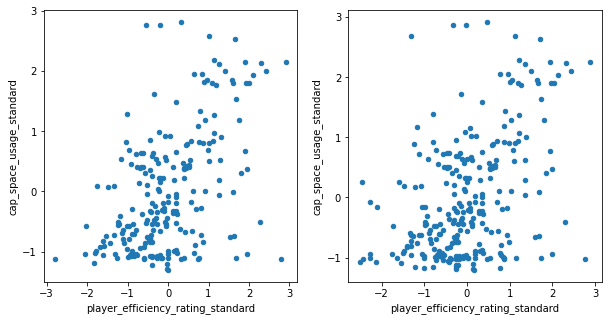

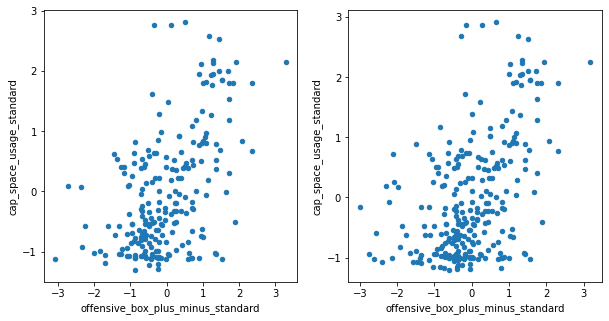

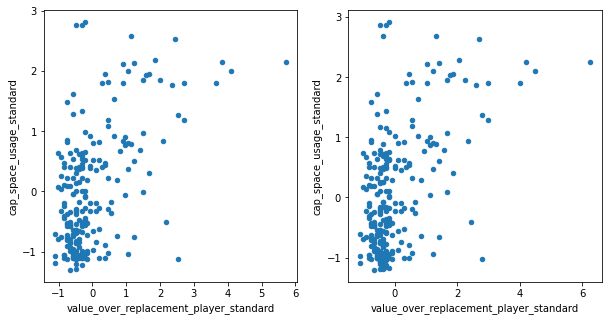

In [37]:
for feature in features_c:
    print(side_by_side_correlation(c_second_round.loc[c_second_round["minutes_played"] >= 200], c_second_round, feature))

(0.3548042228817318, 0.34478036152112385, 'player_efficiency_rating')
(0.41367981629843686, 0.3819007786724306, 'usage_percentage')
(0.34366121114788417, 0.3553005138311208, 'offensive_box_plus_minus')
(0.4992777791589175, 0.5119612007787724, 'value_over_replacement_player')
(0.3381943887113294, 0.322918410674851, 'ast/tov_percentage')
(0.3994143295463678, 0.38334776909943424, 'true_shooting*usage')


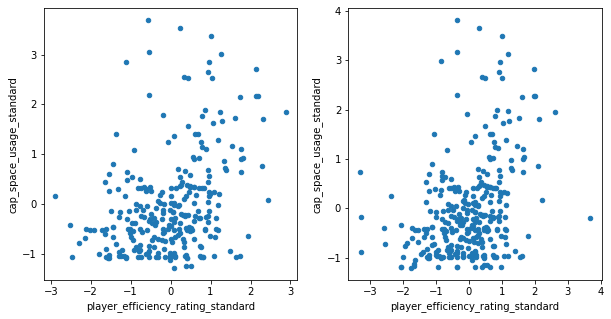

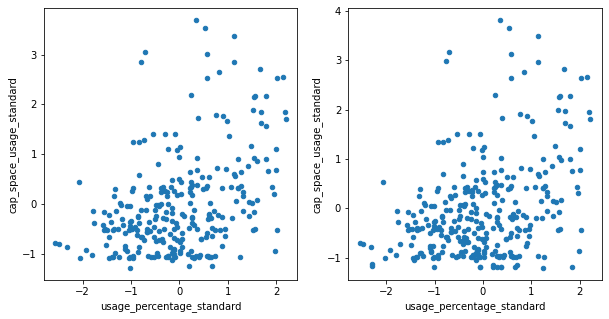

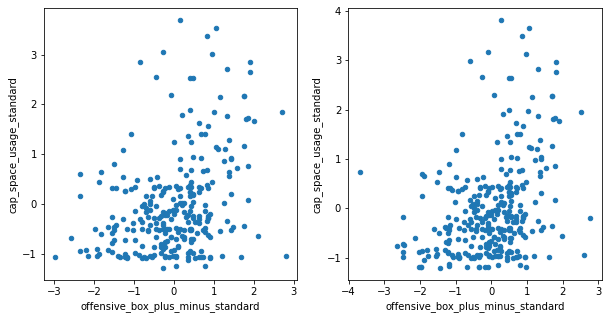

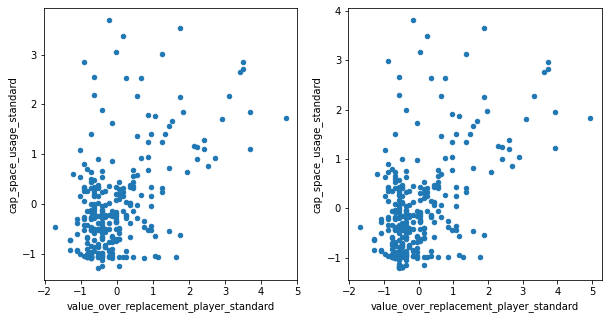

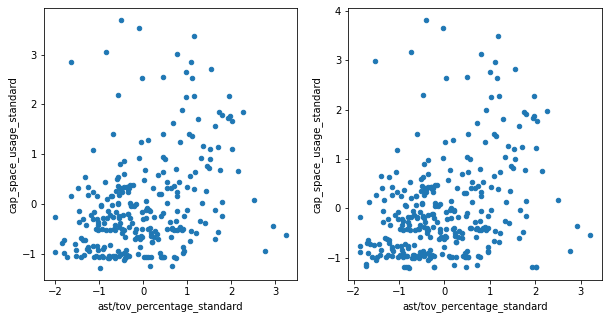

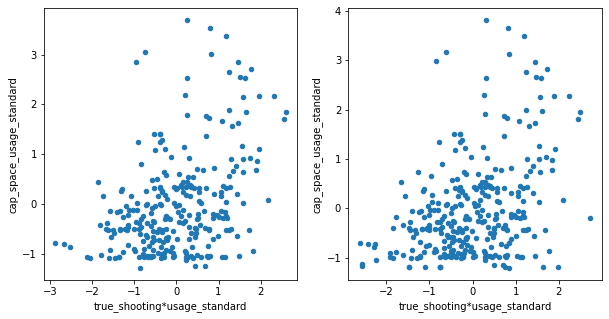

In [36]:
for feature in features_pf:
    print(side_by_side_correlation(pf_second_round.loc[pf_second_round["minutes_played"] >= 200], pf_second_round, feature))

(0.36967297698645885, 0.34385390600112414, 'player_efficiency_rating')
(0.4240881297988682, 0.41073624895594846, 'usage_percentage')
(0.37237433488930777, 0.3323241429843156, 'offensive_box_plus_minus')
(0.35705202076536213, 0.3685685106555707, 'value_over_replacement_player')
(0.31254625777852885, 0.3245874796909714, 'ast/tov_percentage')
(0.43331925843730185, 0.4162264459583696, 'true_shooting*usage')


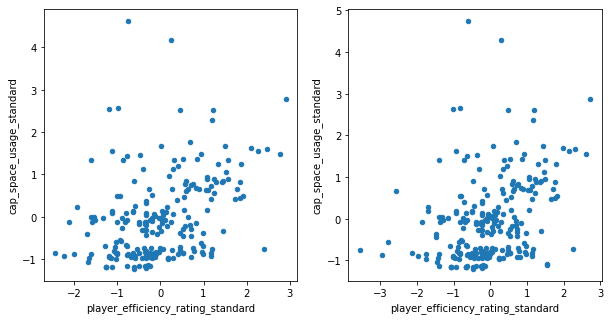

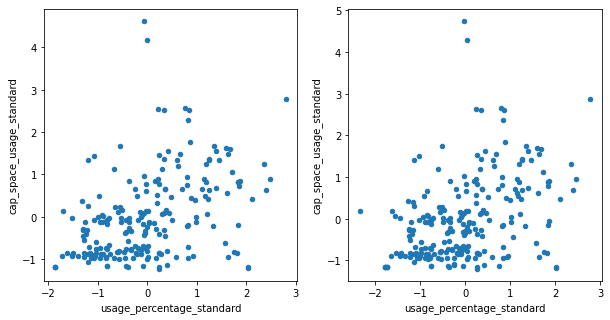

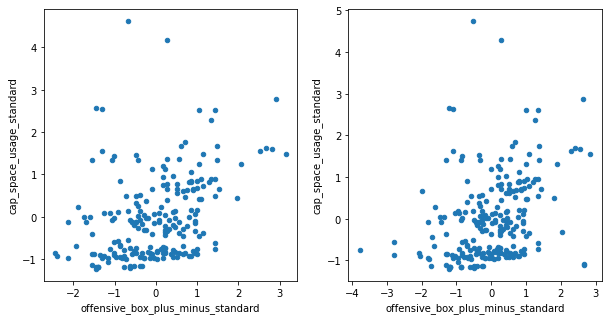

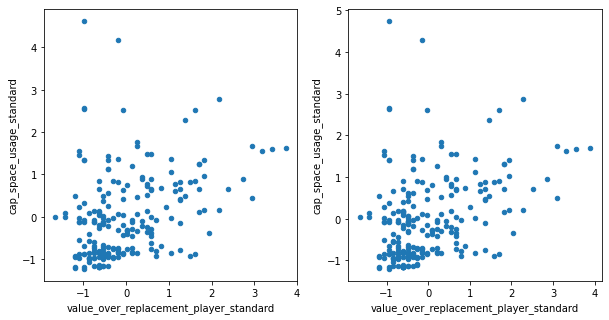

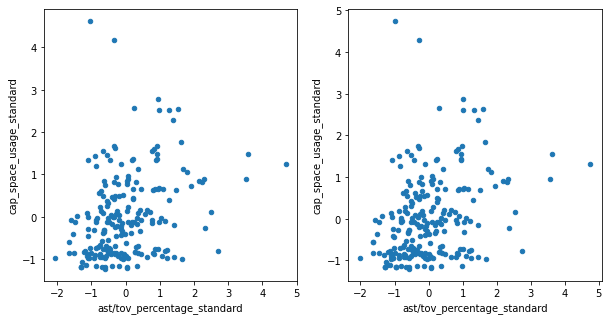

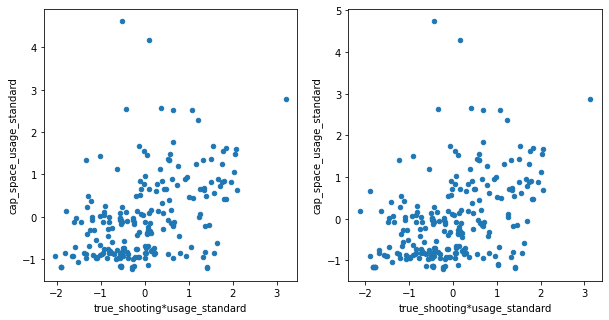

In [35]:
for feature in features_sf:
    print(side_by_side_correlation(sf_second_round.loc[sf_second_round["minutes_played"] >= 200], sf_second_round, feature))

(0.42414082273362985, 0.40064485723484944, 'player_efficiency_rating')
(0.4317348108993882, 0.3864255576703983, 'usage_percentage')
(0.39095318202371965, 0.3620137513023124, 'ast/tov_percentage')
(0.4362253553653511, 0.4174213263787018, 'true_shooting*usage')
(0.3071610862553136, 0.3144378038277698, 'box_plus_minus')


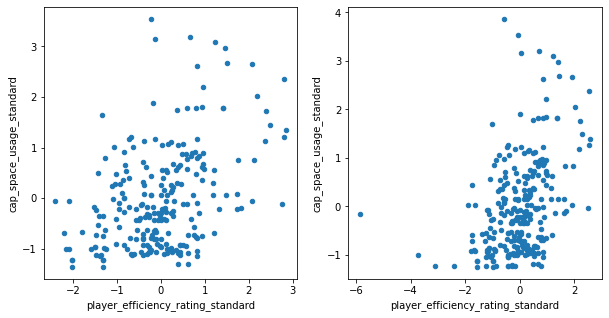

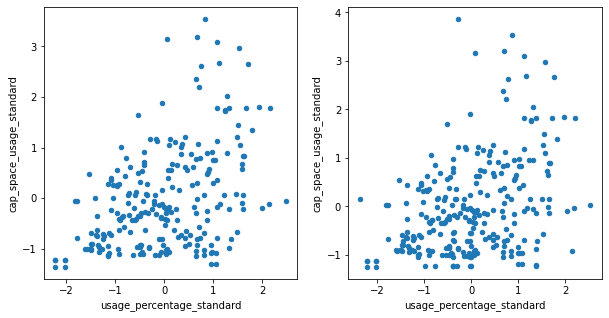

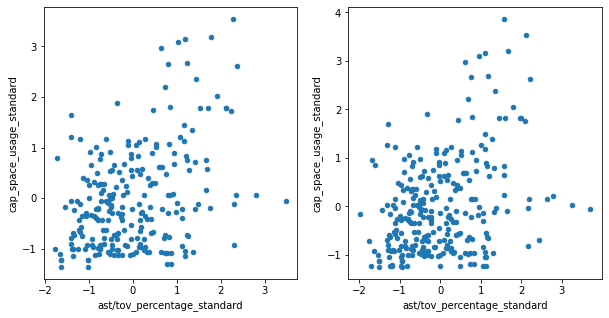

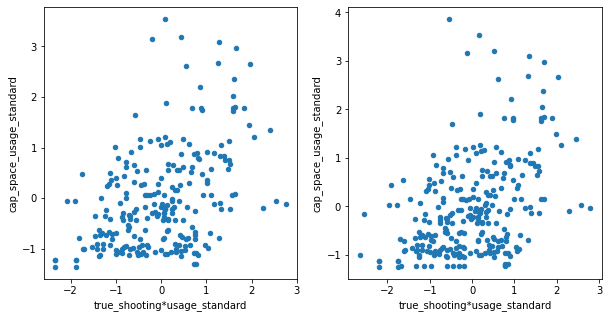

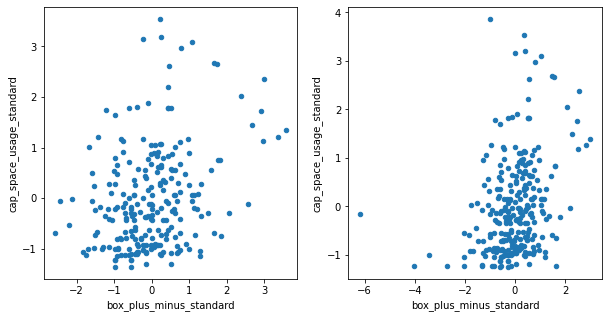

In [34]:
for feature in features_sg:
    print(side_by_side_correlation(sg_second_round.loc[sg_second_round["minutes_played"] >= 200], sg_second_round, feature))

(0.300682630565098, 0.34041354894385034, 'player_efficiency_rating')
(0.24679106433049278, 0.29119613295602437, 'ast/tov_percentage')
(0.3038509955402344, 0.3389082480687075, 'win_shares')
(0.2552800800523334, 0.28426793264314515, 'box_plus_minus')
(0.33703083358837194, 0.3490205615502935, 'value_over_replacement_player')


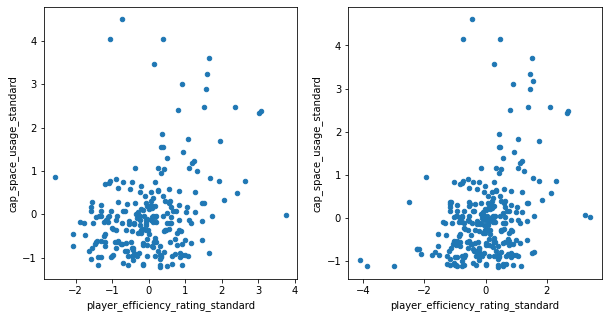

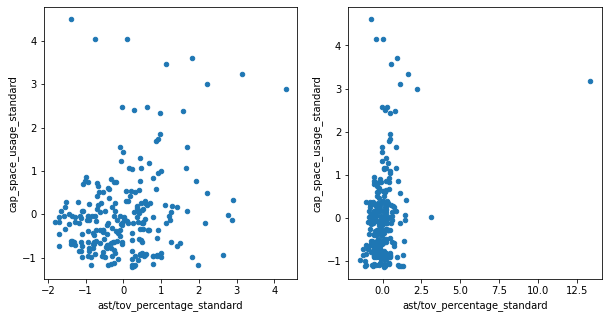

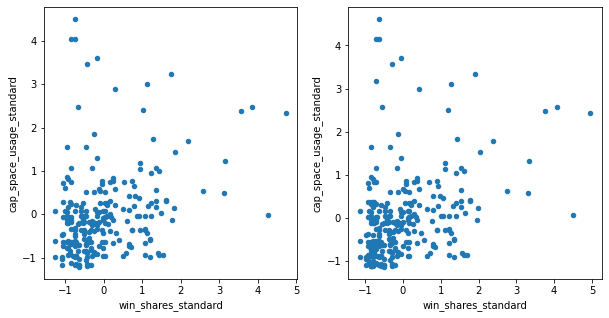

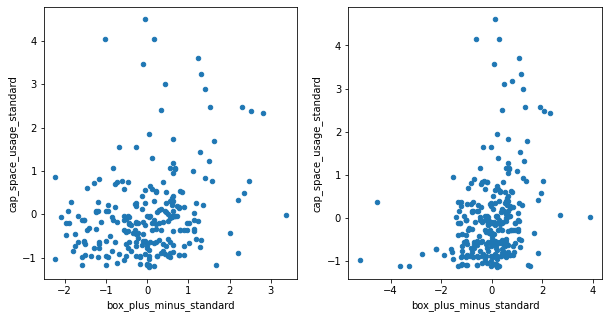

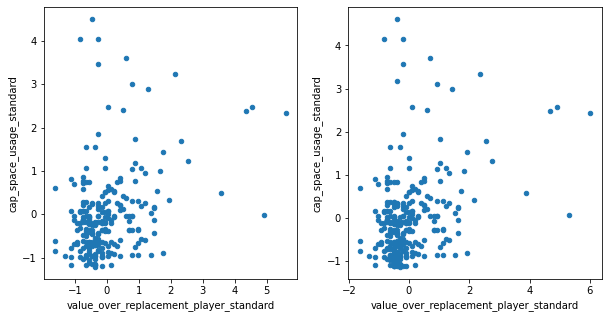

In [33]:
for feature in features_pg:
    print(side_by_side_correlation(pg_second_round.loc[pg_second_round["minutes_played"] >= 200], pg_second_round, feature))